In [1]:
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
import sys

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Cargando data del Google Drive

In [3]:
data_path = '/content/gdrive/MyDrive/Food Detective/food_c101_n10099_r64x64x3.h5'

In [4]:
data_set = h5py.File(data_path, 'r')

In [5]:
data_set

<HDF5 file "food_c101_n10099_r64x64x3.h5" (mode r)>

## Split de datos

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data_set['images'][:], data_set['category'][:], test_size=0.3, random_state=42)

In [7]:
def set_nontrainable_layers(model):
  model.trainable = False    
  return model

## Armado de modelo ResNET50

In [8]:
X_train[0].shape

(64, 64, 3)

In [9]:
def build_model():

  
  resnet = ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
  resnet = set_nontrainable_layers(resnet)
  base_model = resnet
  prediction_layer = layers.Dense(101, activation='softmax')

  model = Sequential([base_model,
                      layers.GlobalAveragePooling2D(),
                      layers.Dropout(0.2),
                      layers.Dense(256, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dropout(0.1),
                      layers.Dense(128, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dropout(0.1),
                      prediction_layer])
  return model

model = build_model()

def compile_model(model):
  model.compile(optimizer = Adam(learning_rate=0.001), 
                  metrics = 'accuracy', 
                  loss='categorical_crossentropy')
  return model


94773248/94765736 [==============================] - 1s 0us/step


## Preprocesado de datos

In [10]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0, 1.5),
    zoom_range=(0.8, 1.2)) 

datagen.fit(X_train)

In [12]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

## Entrenando el modelo

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

train_flow = datagen.flow(X_train, y_train, batch_size=32)
# val_flow = datagen.flow(X_val, y_val, batch_size=32)

model = build_model()
model = compile_model(model)

history = model.fit(train_flow, 
          epochs=300, 
          validation_data=(X_val, y_val),
          callbacks=[es],
          verbose=1, 
          batch_size=32)

Epoch 1/300
221/221 [==============================] - 18s 67ms/step - loss: 4.8581 - accuracy: 0.0272 - val_loss: 4.4161 - val_accuracy: 0.1069
Epoch 2/300
221/221 [==============================] - 14s 62ms/step - loss: 4.1328 - accuracy: 0.0989 - val_loss: 3.8460 - val_accuracy: 0.1627
Epoch 3/300
221/221 [==============================] - 14s 62ms/step - loss: 3.8515 - accuracy: 0.1292 - val_loss: 3.7500 - val_accuracy: 0.1733
Epoch 4/300
221/221 [==============================] - 14s 62ms/step - loss: 3.7508 - accuracy: 0.1475 - val_loss: 3.5723 - val_accuracy: 0.2059
Epoch 5/300
221/221 [==============================] - 14s 62ms/step - loss: 3.6171 - accuracy: 0.1714 - val_loss: 3.5937 - val_accuracy: 0.2050
Epoch 6/300
221/221 [==============================] - 14s 61ms/step - loss: 3.5829 - accuracy: 0.1825 - val_loss: 3.5301 - val_accuracy: 0.2106
Epoch 7/300
221/221 [==============================] - 13s 61ms/step - loss: 3.5020 - accuracy: 0.1917 - val_loss: 3.4866 - val_ac

In [15]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

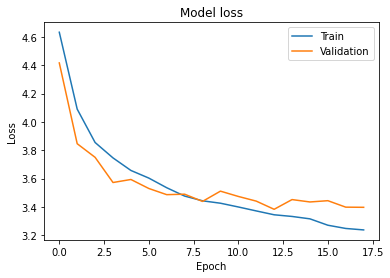

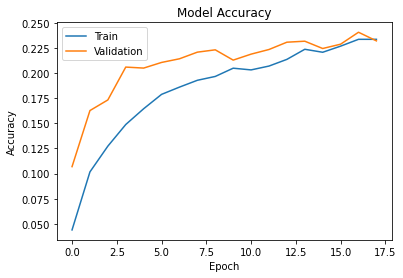

In [16]:
plot_loss_accuracy(history)

## Testeando el modelo

In [17]:
test_path = '/content/gdrive/MyDrive/Food Detective/food_test_c101_n1000_r64x64x3.h5'

In [18]:
test_set = h5py.File(data_path, 'r')

In [19]:
X_test = test_set['images'][:]
y_test = test_set['category'][:]

### Preprocesando test

In [20]:
X_test = preprocess_input(X_test)
y_test = y_test.astype(int)

In [21]:
# test_flow = datagen.flow(X_test, y_test, batch_size=32)

## Evaluando sobre el test set

In [22]:
model.evaluate(X_test, y_test)

316/316 [==============================] - 6s 20ms/step - loss: 2.9565 - accuracy: 0.2930


[2.9565250873565674, 0.2929992973804474]

## Nueva prueba con otra paciencia y mas epochs






In [29]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

model = build_model()
model.compile(optimizer = Adam(learning_rate=0.0001), 
                  metrics = 'accuracy', 
                  loss='categorical_crossentropy')

history = model.fit(train_flow, 
          epochs=500, 
          validation_data=(X_val, y_val), 
          verbose=1, 
          callbacks=[es],
          batch_size=32)

Epoch 1/500
221/221 [==============================] - 17s 66ms/step - loss: 5.1715 - accuracy: 0.0149 - val_loss: 5.0051 - val_accuracy: 0.0281
Epoch 2/500
221/221 [==============================] - 13s 61ms/step - loss: 4.8802 - accuracy: 0.0240 - val_loss: 4.7799 - val_accuracy: 0.0535
Epoch 3/500
221/221 [==============================] - 13s 61ms/step - loss: 4.7039 - accuracy: 0.0415 - val_loss: 4.5424 - val_accuracy: 0.0739
Epoch 4/500
221/221 [==============================] - 13s 61ms/step - loss: 4.5203 - accuracy: 0.0514 - val_loss: 4.4005 - val_accuracy: 0.0901
Epoch 5/500
221/221 [==============================] - 13s 60ms/step - loss: 4.4039 - accuracy: 0.0667 - val_loss: 4.2471 - val_accuracy: 0.1096
Epoch 6/500
221/221 [==============================] - 13s 60ms/step - loss: 4.3381 - accuracy: 0.0768 - val_loss: 4.1334 - val_accuracy: 0.1277
Epoch 7/500
221/221 [==============================] - 13s 60ms/step - loss: 4.2368 - accuracy: 0.0895 - val_loss: 4.0382 - val_ac

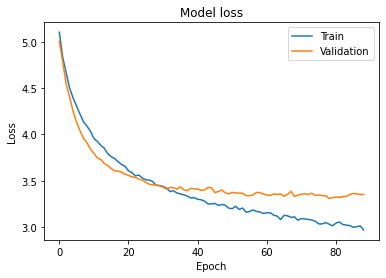

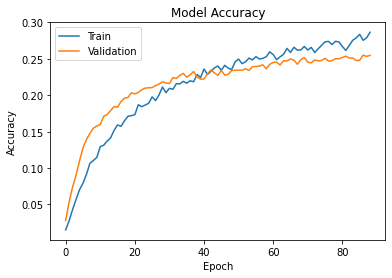

In [30]:
plot_loss_accuracy(history)

## Resultado

In [33]:
model.evaluate(X_test, y_test)

316/316 [==============================] - 6s 18ms/step - loss: 2.7038 - accuracy: 0.3452


[2.703813076019287, 0.3451826870441437]